**Author:** Shahed Sabab  
**Tech Stack:** CrewAI 

---

# Automated Customer Review Response System

## Summary

This notebook demonstrates the implementation of an automated customer review response system using CrewAI, a framework for orchestrating autonomous AI agents. CrewAI enables the creation of a multi-agent network that efficiently handles different aspects of the review response process.

The system leverages the key components of CrewAI:

1. **Agents**: Autonomous units with defined roles, goals, and backstories. Each agent specializes in a particular function within the review response process.

2. **Tasks**: Specific assignments given to agents, complete with clear descriptions and expected outputs.

3. **Tools**: Resources that enhance agents' capabilities, including search engines, data analysis functions, and specialized algorithms.

4. **Crews**: Groups of agents working together, with defined strategies for task execution and collaboration.

The system comprises three specialized crews:

- **Categorizer Crew**: Analyzes and categorizes incoming customer reviews.
- **Researcher Crew**: Gathers relevant information and context for each review.
- **Responder Crew**: Generates tailored responses based on categorized and researched data.
---

<div style="text-align: center;">
    <img src="figure/response_generation_agent.png" alt="Response generation agent diagram" width="1200"/>
</div>

In [32]:
from dotenv import load_dotenv
import os
import os
from groq import Groq
from langchain_groq import ChatGroq
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

import requests
from langchain.tools import tool

import os
from crewai import Agent, Task, Crew, Process
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.agents import load_tools
from langchain.tools.base import Tool

search_tool = DuckDuckGoSearchRun()

from langchain_core.prompts import ChatPromptTemplate
load_dotenv()

True

In [34]:
# Get the Groq API key from environment variables
groq_api_key = os.getenv('GROQ_API_KEY')

if not groq_api_key:
    raise ValueError("GROQ_API_KEY not found in environment variables")

In [36]:
# read data
df = pd.read_csv('survey_unified.csv')

In [38]:
df['length'] = df['survey'].str.len()

In [40]:
df

,survey,rating,hybrid_topic,llm_topic,length
0,A 7 just is right,7,Loved it and satisfied,General Neutral,17
1,"A lot of stuff I don't consume, repetitive off...",5,T-Mobile app navigation issues,App Content,132
2,All perks,9,Enthusiastic about great perks,App Features,9
3,all the above,10,Loved it and satisfied,General Neutral,13
4,always a useful app.,9,App positive feedback,App Usability,20
...,...,...,...,...,...
643,Waiting for internet service in my area,8,Limited local deal offers,Internet Service Availability,39
644,like the old app better,8,Preference for older app,App Usability,23
645,I love tmobile!,10,T-Mobile customer satisfaction,General Positive,15
646,Changes are worse than before,8,Preference for older app,App Functionality,29


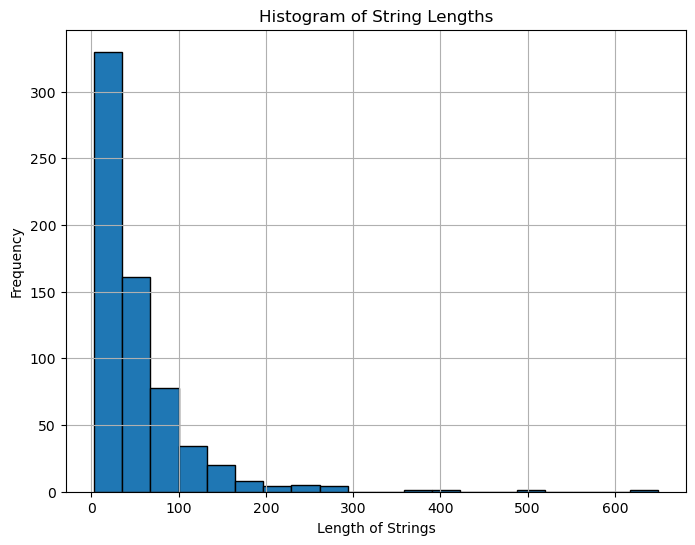

In [42]:
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(df['length'], bins=20, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Length of Strings')
plt.ylabel('Frequency')
plt.title('Histogram of String Lengths')
plt.grid(True)
plt.show()

In [44]:
review_inq = df[df['length']>200]

In [46]:
review_inq

,survey,rating,hybrid_topic,llm_topic,length
111,The app used to have a lot of things that I us...,2,Changes in available Perks,App Features and Usability,245
226,I've tried weekly to apply my T-mobile Hilton ...,4,T-Mobile app navigation issues,Program Functionality Issues,270
239,If it wasn't for the discount on gas it wouldn...,7,Dissatisfaction with App rewards,Rewards and Promotions,250
243,"Most of the perks (travel,concerts, movies out...",6,Changes in available Perks,App Features,203
247,Most deals never work or are complicated with ...,1,Limited local deal offers,Customer Service Issues,230
256,I've never had any serious issues with T-Mobil...,10,T-Mobile customer satisfaction,Customer Service,210
269,Because a lot of these freebies are only free ...,5,T-Mobile app navigation issues,Promotion Accessibility,266
346,The offers are basically useless most of the t...,0,Changes in available Perks,App Offers Quality,403
348,I love all the amazing free items I get from T...,10,Free stuff,App Features,246
350,I was an original Sprint owner of my iPhone si...,0,T-Mobile app navigation issues,Product Issues,496


# Helper methods

In [49]:
import json  # Import the JSON module to parse JSON strings
from langchain_core.agents import AgentFinish

agent_finishes  = []

import json
from typing import Union, List, Tuple, Dict
from langchain.schema import AgentFinish

call_number = 0

def print_agent_output(agent_output: Union[str, List[Tuple[Dict, str]], AgentFinish], agent_name: str = 'Generic call'):
    global call_number  # Declare call_number as a global variable
    call_number += 1
    with open("crew_callback_logs.txt", "a") as log_file:
        # Try to parse the output if it is a JSON string
        if isinstance(agent_output, str):
            try:
                agent_output = json.loads(agent_output)  # Attempt to parse the JSON string
            except json.JSONDecodeError:
                pass  # If there's an error, leave agent_output as is

        # Check if the output is a list of tuples as in the first case
        if isinstance(agent_output, list) and all(isinstance(item, tuple) for item in agent_output):
            print(f"-{call_number}----Dict------------------------------------------", file=log_file)
            for action, description in agent_output:
                # Print attributes based on assumed structure
                print(f"Agent Name: {agent_name}", file=log_file)
                print(f"Tool used: {getattr(action, 'tool', 'Unknown')}", file=log_file)
                print(f"Tool input: {getattr(action, 'tool_input', 'Unknown')}", file=log_file)
                print(f"Action log: {getattr(action, 'log', 'Unknown')}", file=log_file)
                print(f"Description: {description}", file=log_file)
                print("--------------------------------------------------", file=log_file)

        # Check if the output is a dictionary as in the second case
        elif isinstance(agent_output, AgentFinish):
            print(f"-{call_number}----AgentFinish---------------------------------------", file=log_file)
            print(f"Agent Name: {agent_name}", file=log_file)
            agent_finishes.append(agent_output)
            # Extracting 'output' and 'log' from the nested 'return_values' if they exist
            output = agent_output.return_values
            # log = agent_output.get('log', 'No log available')
            print(f"AgentFinish Output: {output['output']}", file=log_file)
            # print(f"Log: {log}", file=log_file)
            # print(f"AgentFinish: {agent_output}", file=log_file)
            print("--------------------------------------------------", file=log_file)

        # Handle unexpected formats
        else:
            # If the format is unknown, print out the input directly
            print(f"-{call_number}-Unknown format of agent_output:", file=log_file)
            print(type(agent_output), file=log_file)
            print(agent_output, file=log_file)


# Vanilla

In [85]:
query = review_inq.iloc[1][0]

C:\Users\sabab\AppData\Local\Temp\ipykernel_32312\1045627795.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = review_inq.iloc[1][0]


In [87]:
query

"I've tried weekly to apply my T-mobile Hilton Honors code to my existing HH account and it never sends the verification email. I've checked spam etc and no email comes through with a code so I can't activate Silver Status as your program promises. Btsylong@sbcglobal.net"

In [89]:
groq_vanilla = ChatGroq(temperature=0, groq_api_key=groq_api_key, model_name="llama3-8b-8192")

In [90]:
system_prompt_vanilla = "You are a helpful assistant in curating response for reviews. Be polite and frinedly and address the issues mentioned in the reviews and generate an appropriate response"

In [93]:
system = system_prompt_vanilla
human = "{text}"
prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])

chain = prompt | groq_vanilla
response = chain.invoke({"text": query})

In [94]:
print(response.content)

Dear Btsylong@sbcglobal.net,

Thank you for reaching out to us about the issue you're experiencing with the T-Mobile Hilton Honors code. We apologize for the inconvenience and frustration this has caused.

We understand that you've been trying to apply the code to your existing Hilton Honors account for several weeks now, but haven't received the verification email. We're sorry to hear that you've checked your spam folder and haven't found the email.

We'd like to help you resolve this issue as soon as possible. Could you please provide us with more information about your attempts to apply the code? This will help us to better understand the issue and assist you more effectively.

Additionally, we'd like to offer you a one-time courtesy to manually verify your code and activate your Silver Status. Please reply to this email with your Hilton Honors account number and we'll take care of the rest.

We appreciate your patience and loyalty to both T-Mobile and Hilton Honors. We're committed

# Crew 

In [444]:
GROQ_LLM = ChatGroq(
            # api_key=os.getenv("GROQ_API_KEY"),
            model="llama3-70b-8192"
        )


In [445]:
search = GoogleSerperAPIWrapper()
google_tool = Tool(
                    name="Intermediate Answer",
                    func=search.run,
                    description="useful for when you need to ask with search"
                )


In [447]:
class ReviewAgents():
    def make_categorizer_agent(self):
        return Agent(
            role='Categorizer Agent',
            goal=""" take the review from a human and categorize it \
            into one of the following categories: \
            deals_and_offers - when someone talks about coupons, offers, promotions, discounts, rewards, and deals\
            service_quality - when someone has anything to say about customer services or overall services provided by the company \
            subscription_services - when someone has anything to say on the subscription services \
            app_usability - when someone has anything to say on the usability, user experience of the app \
            app_feature - used when someone encountered anything with the mobile app or website features\
            network_issues - used when someone is having network issues, call drops, and wifi calling problems\
            off_topic - when it doesn't relate to any other category """,
            backstory="""You are a master at understanding what a customer wants when they write a review and able to categorize it in a useful way.""",
            llm=GROQ_LLM,
            verbose=True,
            allow_delegation=False,
            max_iter=5,
            memory=True,
            step_callback=lambda x: print_agent_output(x ,"Categorizer Agent"),
        )

    def make_researcher_agent(self):
        return Agent(
            role='Info Researcher Agent',
            goal="""take the review from a human and category \
            that the categorizer agent gave it and decide what information you need to search for the responder to reply to \
            the review in a thoughtful and helpful way. \
            If you DONT think a search will help just reply 'NO SEARCH NEEDED' \
            If you DONT find any useful info just reply 'NO USEFUL RESESARCH FOUND' \
            otherwise reply with the info you found that is useful for the responder \
            Try to come up with some resources, while searching use this template \
            "query": [YOUR QUERY]\
            """,
            backstory="""You are a master at understanding what information our responder needs to write a reply that \
            will help the customer. Search by the query to get help.""",
            llm=GROQ_LLM,
            verbose=True,
            max_iter=5,
            allow_delegation=True,
            memory=True,
            tools=[search_tool],
            step_callback=lambda x: print_agent_output(x,"Info Researcher Agent"),
        )

    def make_review_writer_agent(self):
        return Agent(
            role='Responder Agent',
            goal="""take the review from a human and category \
            that the categorizer agent gave it and the research from the research agent and \
            write a helpful response in a thoughtful and friendly way.

            If the customer review is 'off_topic' then ask them questions to get more information.
            If the customer review is 'subscription_services' then try to find out the name of the service and find out the root cause.
            If the customer review is 'service_quality' then try to assure we value them and that we are addressing their issues or appreciate them for positive feedback.
            If the customer review is 'deals_and_offers' then try to find out the issues and address by mentioning that will be solved in the future.
            If the customer review is 'app_usability' then try to address the exact issue and assure them by reporting to the tech team.
            If the customer review is 'app_feature' then try to address the exact issue and assure them that the concern will be reported and soon solved.
            If the customer review is 'network_issues' then try to give a solution.

            You never make up information. that hasn't been provided by the researcher or in the review.
            Always sign off the review in an appropriate manner and from T-mobile Team. And start the reponse saying Dear Customer,
            """,
            backstory="""You are a master at synthesizing a variety of information and writing a helpful response \
            that will address the customer's issues and provide them with helpful information""",
            llm=GROQ_LLM,
            verbose=True,
            allow_delegation=False,
            max_iter=5,
            memory=True,
            step_callback=lambda x: print_agent_output(x,"Responder Agent"),
        )


In [450]:
class ReviewTasks():
    # Define your tasks with descriptions and expected outputs
    def categorize_reviews(self, content, agent):
        return Task(
            description=f"""Conduct a comprehensive analysis of the reviews provided and categorize into \
            one of the following categories:
            deals_and_offers - when someone talks about coupons, offers, promotions, discounts, rewards, and deals\
            service_quality - when someone has anything to say about customer services or overall services provided by the company \
            subscription_services - when someone has anything to say on the subscription services \
            app_usability - when someone has anything to say on the usability, user experience of the app \
            app_feature - used when someone encountered anything with the mobile app or website features\
            network_issues - used when someone is having network issues, call drops, and wifi calling problems\
            off_topic - when it doesn't relate to any other category

            REVIEW CONTENT:\n\n {content} \n\n
            Output a single cetgory only also enlist the value of this category from review""",
            expected_output="""A single categtory for the type of email from the types ('deals_and_offers', 'service_quality', 'subscription_services', 'app_usability', 'app_feature', 'network_issues', 'off_topic') \
            eg:
            'deals_and_offers' \
            """,
            output_file=f"category.txt",
            agent=agent
            )

    def research_info_for_review(self, content, agent):
        return Task(
            description=f"""Conduct a comprehensive analysis of the review provided and the category \
            provided and search to find info needed to respond to the review
            REVIEW CONTENT:\n\n {content} \n\n
            Always try to provide the info needed DONT try to write the response""",
            expected_output="""A set of bullet points of useful info for the responder \
            or clear instructions that no useful material was found.""",
            context = [categorize_reviews],
            output_file=f"research_info.txt",
            agent=agent
            )

    def draft_review(self, content, agent):
        return Task(
            description=f"""Conduct a comprehensive analysis of the review provided, the category provided\
            and the info provided from the research specialist to write a review. \

            Write a simple, polite and too the point email which will respond to the customer's review. \
            If useful use the info provided from the research specialist in the response. \

            If no useful info was provided from the research specialist the answer politely but don't make up info. \

            REVIEW CONTENT:\n\n {content} \n\n
            Output a single cetgory only""",
            expected_output="""A well crafted response for the customer that addresses their issues and concerns""",
            context = [categorize_reviews, research_info_for_review],
            agent=agent,
            output_file=f"draft_response.txt",
            )

In [452]:
r = review_inq.iloc[:,0].values

In [454]:
review = r[1]

In [456]:
# review = "what is happening in the world"

In [458]:
review

"I've tried weekly to apply my T-mobile Hilton Honors code to my existing HH account and it never sends the verification email. I've checked spam etc and no email comes through with a code so I can't activate Silver Status as your program promises. Btsylong@sbcglobal.net"

In [460]:
##
agents = ReviewAgents()
tasks = ReviewTasks()

## Agents
categorizer_agent = agents.make_categorizer_agent()
researcher_agent = agents.make_researcher_agent()
responder_agent = agents.make_review_writer_agent()

## Tasks
categorize_reviews = tasks.categorize_reviews(review, categorizer_agent)
research_info_for_review = tasks.research_info_for_review(review, researcher_agent)
draft_email = tasks.draft_review(review, responder_agent)


In [462]:
from crewai import Crew, Process

# Instantiate your crew with a sequential process
crew = Crew(
    agents=[categorizer_agent, researcher_agent, responder_agent],
    tasks=[categorize_reviews, research_info_for_review, draft_email],
    verbose=2,
    process=Process.sequential,
    full_output=True,
    share_crew=False,
    step_callback=lambda x: print_agent_output(x,"MasterCrew Agent")
)

2024-07-14 16:08:27,083 - 14232 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


In [464]:
# Kick off the crew's work
results = crew.kickoff()


# Print the results
print("Crew Work Results:")
print(results)

# print(f"Categorize Email: {categorize_email.output}")
print(crew.usage_metrics)

 [2024-07-14 16:08:27][DEBUG]: == Working Agent: Categorizer Agent
 [2024-07-14 16:08:27][INFO]: == Starting Task: Conduct a comprehensive analysis of the reviews provided and categorize into             one of the following categories:
            deals_and_offers - when someone talks about coupons, offers, promotions, discounts, rewards, and deals            service_quality - when someone has anything to say about customer services or overall services provided by the company             subscription_services - when someone has anything to say on the subscription services             app_usability - when someone has anything to say on the usability, user experience of the app             app_feature - used when someone encountered anything with the mobile app or website features            network_issues - used when someone is having network issues, call drops, and wifi calling problems            off_topic - when it doesn't relate to any other category

            REVIEW CONTENT:

 